# Visualize How Node Embeddings Work
__A Gentle Introduction by Example Using Neo4j Graph Data Science__

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neo4j-product-examples/demo-fraud-detection-with-p2p/blob/main/abridged-demo/fraud-detection-demo-with-p2p.ipynb)
![Neo4j version](https://img.shields.io/badge/Neo4j->=4.4.9-brightgreen)
![GDS version](https://img.shields.io/badge/GDS->=2.3-brightgreen)
![GDS Python Client version](https://img.shields.io/badge/GDS_Python_Client->=1.6-brightgreen)
<img src="https://github.com/neo4j-product-examples/graph-machine-learning-examples/blob/main/short-examples/img/embedding-vis-karate-club.png" width="500" >

This notebooks demonstrates how node embeddings encapsulate graph structure in a convenient representation for use in visualization, clustering, and ML feature engineering. Specifically we will use Neo4j Graph Data Science with scikit-learn TSNE to:

* Create a graph projection of [Zachary's karate club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)
* Run [Louvain community detection](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/) and [FastRP node embedding]()
* Export results to Python
* Use TSNE from scikit-learn to create a 2-dimensional representations of the embeddings
* Visualize the embedding 2-d representation and show how it aligns to the Karate Club graph structure

## Prerequisites

Running this notebook requires a Neo4j instance with a recent Graph Data Science version (2.3+) installed.
We recommend using a [blank Neo4j Sandbox](https://sandbox.neo4j.com/?usecase=blank-sandbox) or [Neo4j Desktop with Graph Data Science installed](https://neo4j.com/docs/graph-data-science/current/installation/neo4j-desktop/)

Also required are of course the Python libraries:

* `graphdatascience` (see [docs](https://neo4j.com/docs/graph-data-science-client/current/installation/) for installation instructions)
* `scikit-learn` (see [scikit-learn  docs](https://scikit-learn.org/stable/install.html) for installation instructions)

## Setup

We start by importing our dependencies and setting up our Graph Data Science client connection to the Neo4j.

In [1]:
%%capture
# Install necessary dependencies
%pip install graphdatascience pandas networkx matplotlib adjustText python-dotenv

In [2]:
# Import dependencies
import os
from dotenv import load_dotenv
import pandas as pd
from graphdatascience import GraphDataScience
import numpy as np
from sklearn.manifold import TSNE
import math
from typing import Any
import matplotlib.pyplot as plt
from adjustText import adjust_text
import networkx as nx

In [3]:
# Assign a random seed for consistent use later
RANDOM_SEED = 7474

In [4]:
# Adjust Dataframe display options
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 0)

### Connect to Neo4j Graph Data Science
documentation: [https://neo4j.com/docs/graph-data-science-client/current/getting-started/#_import_and_setup](https://neo4j.com/docs/graph-data-science-client/current/getting-started/#_import_and_setup)

The below cell must load credentials from a `db-credentials.env` file. You can create one by making a copy of the template file, `db-credentials.env.template`, filling in as appropriate, and placing in the same directory as this notebook.

In [5]:
load_dotenv('db-credentials.env', override=True)

# Use Neo4j URI and credentials according to our setup
gds = GraphDataScience(
    os.getenv('NEO4J_URI'),
    auth=(os.getenv('NEO4J_USERNAME'),
          os.getenv('NEO4J_PASSWORD')),
    aura_ds=eval(os.getenv('AURA_DS').title()))

gds.set_database("neo4j")

## Create Graph Projection

In [6]:
if gds.graph.exists('karate_club').exists:
    gds.graph.get('karate_club').drop()
G = gds.graph.load_karate_club('karate_club', undirected=True)

In [7]:
# Inspect some graph metadata and statistics
print(f"Metadata for our loaded graph `G`: {G}")
print(f"Node labels present in `G`: {G.node_labels()}")

Metadata for our loaded graph `G`: Graph(name=karate_club, node_count=34, relationship_count=156)
Node labels present in `G`: ['Person']


## Run Louvain and FastRP Node Embedding

Run [Louvain Community Detection]() to find clusters of highly interconnected nodes in the graph. We can use this to color code clusters in the graph which will help with visualization later.

In [8]:
gds.louvain.mutate(G, mutateProperty='communityId')

Louvain:   0%|          | 0/100 [00:00<?, ?%/s]

mutateMillis                                                                                                                                                                                                                                                                                                                                                        0
nodePropertiesWritten                                                                                                                                                                                                                                                                                                                                              34
                                                                                                                                                                                             ...                                                                                            

Run [FastRP Node Embedding]() this will create numeric vectors for each node.  If the embeddings are done well, nodes that are similar in the graph will also have similar embedding vectors. 

In [9]:
gds.fastRP.mutate(G, mutateProperty='embedding', embeddingDimension=16, randomSeed=RANDOM_SEED)

nodePropertiesWritten                                                                                                                                                                                                                                                                                                                                                                                 34
mutateMillis                                                                                                                                                                                                                                                                                                                                                                                           0
                                                                                                                                                                                                              ...     

## Export Results to Python

We will start by exporting the node propeties into a pandas dataframe. These contain the results of Louvain and FastRP.  After that we will export the relationships and create a local Networkx graph to help with visualization.

### Export Node Properties 
Louvain Community Detection and FastRP Node Embeddings results

In [10]:
node_df = gds.graph.nodeProperties.stream(G,
                                          node_properties=['communityId', 'embedding'],
                                          separate_property_columns=True)
node_df

,nodeId,communityId,embedding
0,1,3,"[-0.48880064487457275, 0.15596821904182434, -0.937694787979126, -0.07336410880088806, -0.14943209290504456, 0.007347539998590946, 0.33008572459220886, 0.1566210389137268, 1.026620864868164, -0.37652426958084106, 0.35821208357810974, 0.07278202474117279, 0.4098731577396393, -0.04160077124834061, 0.14701083302497864, -0.261142373085022]"
1,2,3,"[-0.536891758441925, 0.42844074964523315, -0.7522672414779663, -0.09313241392374039, 0.014569222927093506, 0.41259393095970154, 0.6905478239059448, -0.08961854875087738, 0.9235842227935791, -0.27697527408599854, 0.08065234869718552, 0.325420081615448, 0.5157275795936584, -0.026866406202316284, 0.07859102636575699, -0.439409077167511]"
...,...,...,...
32,33,32,"[-0.22804297506809235, 0.018044263124465942, -0.17964699864387512, 0.46018779277801514, 0.2661057114601135, 0.04669547080993652, 0.10799144208431244, -0.3629198670387268, 0.8195000886917114, -0.20556092262268066, -0.27560022473335266, 0.9457978010177612, 0.2676759362220764, 0.7180927991867065, 0.4722493290901184, -0.10025632381439209]"
33,34,32,"[-0.3134612739086151, 0.05550871416926384, -0.2219359278678894, 0.4016338586807251, 0.2727771997451782, 0.049334242939949036, 0.10172206908464432, -0.3658997416496277, 0.8559666872024536, -0.20321713387966156, -0.2744166851043701, 0.9117282629013062, 0.2755557596683502, 0.6505535244941711, 0.492485374212265, -0.1411575973033905]"


### Export Relationships and Create a Local Networkx Graph

In [11]:
rel_df = gds.beta.graph.relationships.stream(G)
rel_df

,sourceNodeId,targetNodeId,relationshipType
0,1,2,KNOWS
1,1,3,KNOWS
...,...,...,...
154,34,32,KNOWS
155,34,33,KNOWS


In [12]:
Gnx = nx.from_pandas_edgelist(rel_df, 'sourceNodeId', 'targetNodeId')

## Use TSNE to Create a 2D Representation of Embeddings

In [13]:
# instantiate the TSNE model
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, init='random', learning_rate="auto")
# Use the TSNE model to fit and output a 2-d representation
E = tsne.fit_transform(np.stack(node_df['embedding'], axis=0))

Next we will apply some rotation and centering to the 2-d representation. This doesn't change the relative positions between nodes or any information encapsulated in the representation. Rather this just rotates and moves the 2-d space to make things visually easier to follow....basically just making things "prettier".  The parameters I used were manually tweaked to get a better visual.  You can experiment yourself with different parameters if you like.

In [14]:
# helper function to adjust the 2-d representation through rotation, scaling and centering
def rotation_scale_and_shift_matrix(E: np.ndarray, rotation_rad: float = 0.0, scale: float = 1.0,
                              center_at_zero: bool = True) -> np.ndarray:
    R = np.array([[math.cos(rotation_rad), -math.sin(rotation_rad)],
                  [math.sin(rotation_rad), math.cos(rotation_rad)]])
    Z = np.matmul(E, R) * scale
    if center_at_zero:
        Z = Z - Z.mean(axis=0, keepdims=True)
    return Z

# Adjust with rotation and centering (no scaling)
Z = rotation_scale_and_shift_matrix(E, rotation_rad=1.8)

In [15]:
# Merge 2-d representation to dataframe for use as coordinates
node_coord_df = pd.concat([node_df, pd.DataFrame(Z, columns=['x', 'y'])], axis=1)
node_coord_df

,nodeId,communityId,embedding,x,y
0,1,3,"[-0.48880064487457275, 0.15596821904182434, -0.937694787979126, -0.07336410880088806, -0.14943209290504456, 0.007347539998590946, 0.33008572459220886, 0.1566210389137268, 1.026620864868164, -0.37652426958084106, 0.35821208357810974, 0.07278202474117279, 0.4098731577396393, -0.04160077124834061, 0.14701083302497864, -0.261142373085022]",0.368010,0.500436
1,2,3,"[-0.536891758441925, 0.42844074964523315, -0.7522672414779663, -0.09313241392374039, 0.014569222927093506, 0.41259393095970154, 0.6905478239059448, -0.08961854875087738, 0.9235842227935791, -0.27697527408599854, 0.08065234869718552, 0.325420081615448, 0.5157275795936584, -0.026866406202316284, 0.07859102636575699, -0.439409077167511]",0.550678,0.137397
...,...,...,...,...,...
32,33,32,"[-0.22804297506809235, 0.018044263124465942, -0.17964699864387512, 0.46018779277801514, 0.2661057114601135, 0.04669547080993652, 0.10799144208431244, -0.3629198670387268, 0.8195000886917114, -0.20556092262268066, -0.27560022473335266, 0.9457978010177612, 0.2676759362220764, 0.7180927991867065, 0.4722493290901184, -0.10025632381439209]",-0.180042,-0.576150
33,34,32,"[-0.3134612739086151, 0.05550871416926384, -0.2219359278678894, 0.4016338586807251, 0.2727771997451782, 0.049334242939949036, 0.10172206908464432, -0.3658997416496277, 0.8559666872024536, -0.20321713387966156, -0.2744166851043701, 0.9117282629013062, 0.2755557596683502, 0.6505535244941711, 0.492485374212265, -0.1411575973033905]",-0.132403,-0.524960


## Visualize how Embeddings Encapsolute Graph Structure

Before plotting lets assign colors to each communityId to make it easier  to visualize

In [16]:
# helper function and colors pallet
DEFAULT_COLOR_PALETTE = ['#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']

def assign_community_names_and_colors(df: pd.DataFrame, community_id_col: str = 'communityId',
                                      color_palette: str = DEFAULT_COLOR_PALETTE) -> pd.DataFrame:
    comm_df = df[[community_id_col]].drop_duplicates()
    if comm_df.shape[0] > len(color_palette):
        raise Exception("color_palette isn't long enough. Not enough colors for each community")
    comm_df['communityName'] = [f'comm_{i}' for i in range(1,comm_df.shape[0]+1)]
    comm_df['communityColor'] = [color_palette[i] for i in range(comm_df.shape[0])]
    return pd.merge(df, comm_df, on=community_id_col).set_index('nodeId', drop=False)

In [17]:
node_coord_df = assign_community_names_and_colors(node_coord_df)
node_coord_df[['nodeId', 'communityId', 'communityColor']]

,nodeId,communityId,communityColor
nodeId,,,
1,1,3,#E69F00
2,2,3,#E69F00
...,...,...,...
29,29,25,#F0E442
32,32,25,#F0E442


### Creating Visualizations
Use matplotlib to show the graph side-by-side against the 2d embedding representation

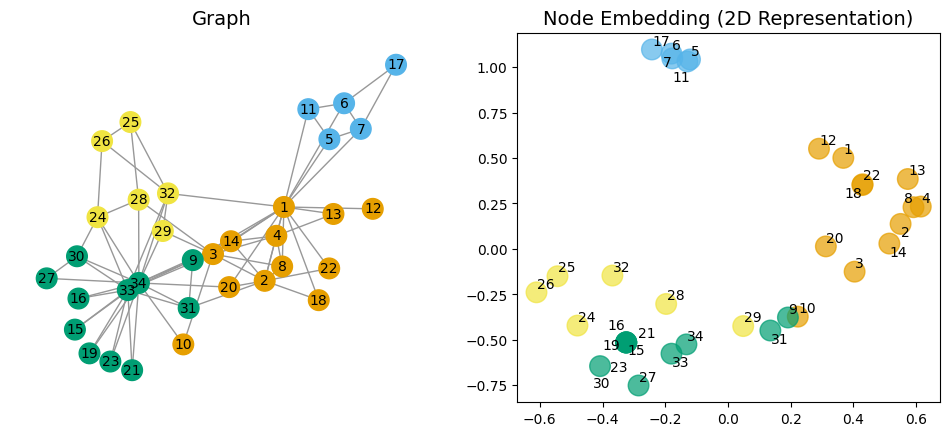

In [18]:
plt.figure().set_figwidth(12)

# Visual the Graph with Networkx
plt.subplot(121)
plt.title('Graph', fontsize=14)
node_pos = nx.spring_layout(Gnx, seed=200)
nx.draw(Gnx, 
        pos=node_pos, 
        with_labels=True, 
        node_color=[node_coord_df.communityColor[n] for n in Gnx],
        edge_color='#989898',
        node_size=220,
        font_size=10)

# Visualize the 2-d representation of embeddings
plt.subplot(122)
plt.title('Node Embedding (2D Representation)', fontsize=14)
plt.scatter(node_coord_df.x, 
            node_coord_df.y, 
            s=220, 
            marker='o', 
            c=node_coord_df.communityColor, 
            alpha=0.7)
texts = [plt.text(node_coord_df.x.iloc[i], 
                  node_coord_df.y.iloc[i], 
                  node_coord_df.nodeId.iloc[i], 
                  fontsize=10) for i in range(node_coord_df.shape[0])]
adjust_text(texts)
plt.savefig('embedding-and-graph-vis.svg', dpi=1000)

Notice how nodes that are similar in the graph our positioned in an approximately similar way in the 2d embedding representation.  This is the purpose of node embeddings.  In application, instead of using TSNE to represent the embeddings in 2d space, we could pass them to downstream ML tasks such as classification, link prediction, anomaly detection, similarity, and more.